# Emotion Detection from scratch


**Description:** Training an image classifier from scratch on the Kaggle FER-2013 Dataset.

**Model used:** Resnet50v2

# Data Set-

Kaggle - https://www.kaggle.com/datasets/msambare/fer2013
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)


# Setting up Kaggle Directory

In [ ]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot create regular file '/root/.kaggle/': Not a directory


In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 78% 47.0M/60.3M [00:00<00:00, 252MB/s]
100% 60.3M/60.3M [00:00<00:00, 254MB/s]


In [ ]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

# Installing Packages

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

# Setting up Directory to save model data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.flush_and_unmount()


# Data Cleaning

In [ ]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

# Data Analysis

In [ ]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = '/content/train'
test_dir = '/content/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


       fear  disgust  neutral   sad  surprise  happy  angry
train  4097      436     4965  4830      3171   7215   3995
      fear  disgust  neutral   sad  surprise  happy  angry
test  1024      111     1233  1247       831   1774    958


<Axes: >

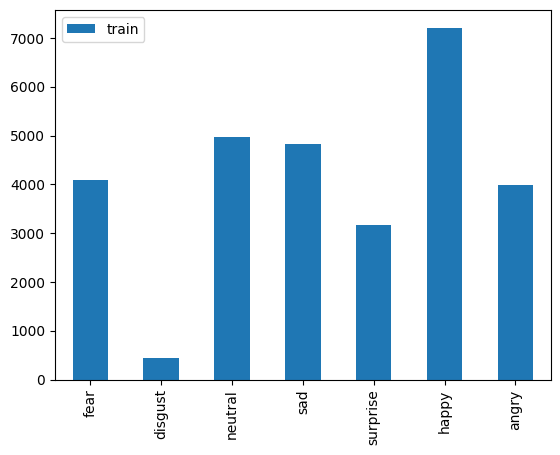

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

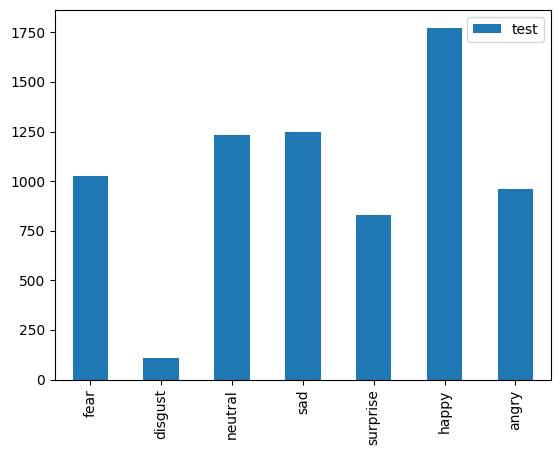

In [ ]:
test_count.transpose().plot(kind='bar')

# Plotting one image from each emotion.

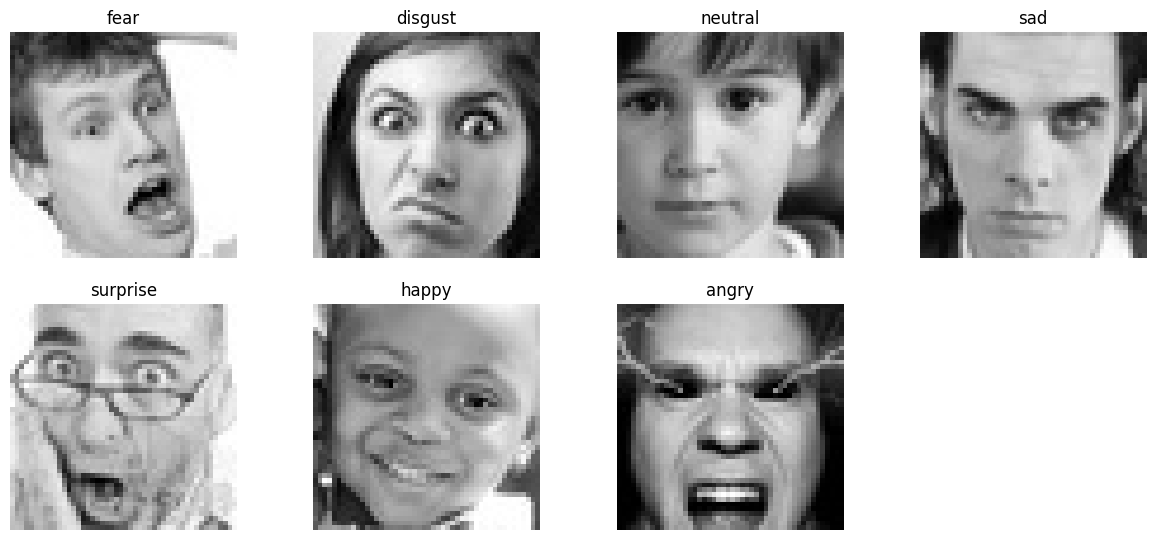

In [ ]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

# Plotting random images from given directory

In [ ]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

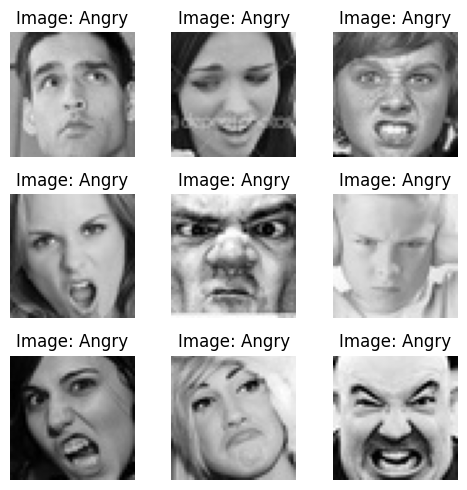

In [ ]:
# Placeholder for the directory path
angry_directory_path = '/content/train/angry'  # Replace with your directory path
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

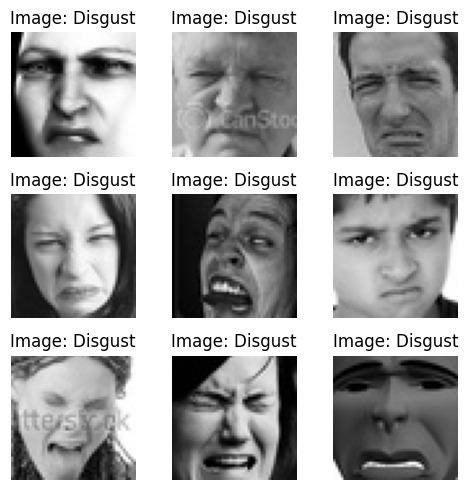

In [ ]:
# Placeholder for the directory path
disgust_directory_path = '/content/train/disgust'  # Replace with your directory path
plot_images_from_directory(disgust_directory_path, class_name = 'Disgust')

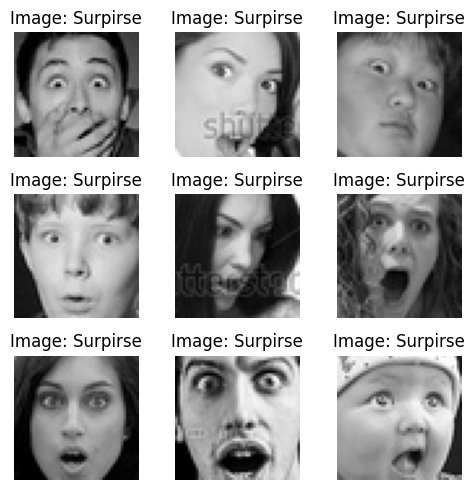

In [ ]:
# Placeholder for the directory path
surpirse_directory_path = '/content/train/surprise'  # Replace with your directory path
plot_images_from_directory(surpirse_directory_path, class_name = 'Surpirse')

# Checking shapes and channels.

In [ ]:
image = '/content/train/angry/Training_10118481.jpg'

import cv2

img = cv2.imread(image) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


In [ ]:
import cv2

image_path = '/content/train/angry/Training_10118481.jpg'

# Load the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)  # This should now print (48, 48)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


# Plotting Performance Metrics

In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Model 4 : Transfer Leanring - ResNet50

In [ ]:
# Directory paths for training and testing data
train_dir = '/content/train'
test_dir = '/content/test'

# Batch size for data generators
batch_size = 64

# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(
                                  rescale=1 / 255.,  # Rescale pixel values to [0,1]
                                  rotation_range=10,  # Random rotation within range [-10,10] degrees
                                  zoom_range=0.2,  # Random zoom between [0.8, 1.2]
                                  width_shift_range=0.1,  # Random horizontal shift within range [-0.1, 0.1]
                                  height_shift_range=0.1,  # Random vertical shift within range [-0.1, 0.1]
                                  horizontal_flip=True,  # Random horizontal flip
                                  fill_mode='nearest'  # Fill mode for handling newly created pixels
                                 )

# Configuration for testing data (only rescaling)
test_datagen = ImageDataGenerator(
                                  rescale=1 / 255.  # Rescale pixel values to [0,1]
                                 )

# Data generators for training and testing data
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,  # Directory containing training data
                                                    class_mode="categorical",  # Classification mode for categorical labels
                                                    target_size=(224, 224),  # Resize input images to (224,224)
                                                    color_mode='rgb',  # Color mode for images (RGB)
                                                    shuffle=True,  # Shuffle training data
                                                    batch_size=batch_size,  # Batch size for training
                                                    subset='training'  # Subset of data (training)
                                                   )

test_generator = test_datagen.flow_from_directory(
                                                  test_dir,  # Directory containing testing data
                                                  class_mode="categorical",  # Classification mode for categorical labels
                                                  target_size=(224, 224),  # Resize input images to (224,224)
                                                  color_mode="rgb",  # Color mode for images (RGB)
                                                  shuffle=False,  # Do not shuffle testing data
                                                  batch_size=batch_size  # Batch size for testing
                                                 )


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Introducing  Static Class wieghts for imbalanced data

In [ ]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
# Used these weights after model had learned decent amount of parameters,
# These were used  as inverse of recall value of each of the emotion class in classification report.

initial_class_weights= {
    0: 0.18035,
    1: 0.066559,
    2: 0.3993546,
    3: 0.0698870,
    4: 0.0947621,
    5: 0.1164784,
    6: 0.0726099

}

In [ ]:
a = [1/0.31, 1/0.84, 1/0.14, 1/0.80, 1/0.59, 1/0.48, 1/0.77]

for i in a:
  print(i/17.886)

0.18035370969545475
0.06655910714951306
0.3993546428970783
0.06988706250698871
0.09476211865354402
0.11647843751164785
0.07260993507219606


## Dynamic Class Weight using callbacks

In [ ]:
class DynamicClassWeightCallback(tf.keras.callbacks.Callback):
    def __init__(self, train_generator):
        super().__init__()
        self.train_generator = train_generator

    def on_epoch_end(self, epoch, logs=None):
        # Recompute class weights dynamically using recall
        y_true = self.train_generator.classes
        y_pred = self.model.predict(self.train_generator, verbose=0)
        y_pred_classes = y_pred.argmax(axis=1)

        # Calculate new class weights
        from sklearn.metrics import recall_score
        recalls = recall_score(y_true, y_pred_classes, average=None)
        class_weights = {i: 1 / recall for i, recall in enumerate(recalls) if recall > 0}

        # Update weights
        self.model.class_weight = class_weights
        print(f"Updated Class Weights for Epoch {epoch + 1}: {class_weights}")


In [ ]:
dynamic_class_weight_callback = DynamicClassWeightCallback(train_generator)

## Training Resnet50v2 for first time

In [ ]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

In [ ]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [ ]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(0.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [ ]:
model = Create_ResNet50V2_Model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,422,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,996,295 (114.43 MB)

 Trainable params: 22,779,527 (86.90 MB)

 Non-trainable params: 7,216,768 (27.53 MB)

## Model parameters settings

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)


In [ ]:
from tensorflow.keras.metrics import Recall
# optimizer = Adam(learning_rate=1e-5)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy',Recall(name='recall_0', class_id=0),   # Angry
                        Recall(name='recall_1', class_id=1),  # Disgust
                        Recall(name='recall_2', class_id=2),  # Fear
                        Recall(name='recall_3', class_id=3),  # Happy
                        Recall(name='recall_4', class_id=4),  # Neutral
                        Recall(name='recall_5', class_id=5),  # Sad
                        Recall(name='recall_6', class_id=6)]  # Surprise
)

## callbacks settings

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/drive/MyDrive/Colab Notebooks/resnet_0.60_increase_4th_jan'
name = 'resnet50_model.keras'
chk_path = os.path.join(cnn_path, name)

In [ ]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

In [ ]:
# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 15,
                          restore_best_weights = True,
                          verbose=1)

In [ ]:
# Callback to reduce learning rate
# reduce_lr = ReduceLROnPlateau(monitor='val_loss',
#                               factor=0.2,
#                               patience=2,
# #                             min_lr=0.00005,
#                               verbose=1)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, csv_logger]  # Adjusted as per your use-case

In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size
test_steps_epoch = test_generator.samples // test_generator.batch_size

## model training

In [ ]:
train_history = model.fit(
                          train_generator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=50,
                          validation_data=test_generator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_weights_dict,
                          callbacks = callbacks + [dynamic_class_weight_callback]
                         )

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.6562 - loss: 1.0176 - recall_0: 0.4459 - recall_1: 0.5600 - recall_2: 0.4783 - recall_3: 0.7640 - recall_4: 0.4639 - recall_5: 0.3143 - recall_6: 0.6672
Epoch 1: val_loss improved from inf to 0.98333, saving model to /content/drive/MyDrive/Colab Notebooks/resnet_0.60_increase_4th_jan/resnet50_model.keras
Updated Class Weights for Epoch 1: {0: 7.942345924453281, 1: 24.22222222222222, 2: 8.661733615221987, 3: 4.269230769230769, 4: 4.834469328140214, 5: 6.616438356164384, 6: 8.47860962566845}
448/448 ━━━━━━━━━━━━━━━━━━━━ 832s 2s/step - accuracy: 0.6562 - loss: 1.0175 - recall_0: 0.4458 - recall_1: 0.5602 - recall_2: 0.4782 - recall_3: 0.7640 - recall_4: 0.4639 - recall_5: 0.3144 - recall_6: 0.6673 - val_accuracy: 0.6518 - val_loss: 0.9833 - val_recall_0: 0.4457 - val_recall_1: 0.6486 - val_recall_2: 0.3066 - val_recall_3: 0.8371 - val_recall_4: 0.6042 - val_recall_5: 0.3376 - val_recall_6: 0.7686
Epoch 2/50
  1/448 ━━━━━━━━━━━━━━━━━

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.98333 to 0.26444, saving model to /content/drive/MyDrive/Colab Notebooks/resnet_0.60_increase_4th_jan/resnet50_model.keras
Updated Class Weights for Epoch 2: {0: 8.10344827586207, 1: 31.142857142857142, 2: 8.829741379310345, 3: 4.120502569960022, 4: 4.648876404494382, 5: 7.144970414201184, 6: 8.640326975476839}
448/448 ━━━━━━━━━━━━━━━━━━━━ 340s 760ms/step - accuracy: 0.6406 - loss: 0.8692 - recall_0: 0.1667 - recall_1: 1.0000 - recall_2: 0.4545 - recall_3: 0.7333 - recall_4: 0.6364 - recall_5: 0.6667 - recall_6: 0.6250 - val_accuracy: 0.8000 - val_loss: 0.2644 - val_recall_0: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_recall_6: 0.8000
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.6713 - loss: 0.8884 - recall_0: 0.4363 - recall_1: 0.7597 - recall_2: 0.4424 - recall_3: 0.7662 - recall_4: 0.4997 - recall_5: 0.3657 - recall_6:

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Updated Class Weights for Epoch 4: {0: 7.4812734082397006, 1: 43.599999999999994, 2: 4.960048426150121, 3: 4.170520231213873, 4: 6.214017521902378, 5: 7.102941176470588, 6: 8.759668508287293}
448/448 ━━━━━━━━━━━━━━━━━━━━ 325s 726ms/step - accuracy: 0.6719 - loss: 0.7968 - recall_0: 0.6000 - recall_1: 1.0000 - recall_2: 0.4545 - recall_3: 0.6471 - recall_4: 0.3846 - recall_5: 0.5000 - recall_6: 0.6250 - val_accuracy: 0.9000 - val_loss: 0.2750 - val_recall_0: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_recall_6: 0.9000
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.6815 - loss: 0.8586 - recall_0: 0.4546 - recall_1: 0.8115 - recall_2: 0.4498 - recall_3: 0.7851 - recall_4: 0.4883 - recall_5: 0.3765 - recall_6: 0.7299
Epoch 5: val_loss did not improve from 0.26444
Updated Class Weights for Epoch 5: {0: 7.653256704980842, 1: 12.457142857142857, 2: 6.897306397306397

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Updated Class Weights for Epoch 6: {0: 8.428270042194093, 1: 17.439999999999998, 2: 7.027444253859349, 3: 4.202096680256261, 4: 5.759860788863109, 5: 6.474530831099195, 6: 9.299120234604105}
448/448 ━━━━━━━━━━━━━━━━━━━━ 325s 727ms/step - accuracy: 0.7500 - loss: 1.2796 - recall_0: 0.2727 - recall_1: 0.5000 - recall_2: 0.7273 - recall_3: 0.8947 - recall_4: 0.5455 - recall_5: 0.5000 - recall_6: 0.7500 - val_accuracy: 0.9000 - val_loss: 0.4483 - val_recall_0: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_recall_6: 0.9000
Epoch 7/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.6870 - loss: 0.8380 - recall_0: 0.4818 - recall_1: 0.8144 - recall_2: 0.4288 - recall_3: 0.7794 - recall_4: 0.5022 - recall_5: 0.3964 - recall_6: 0.7600
Epoch 7: val_loss did not improve from 0.26444
Updated Class Weights for Epoch 7: {0: 8.10344827586207, 1: 18.956521739130434, 2: 6.555199999999999, 

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Updated Class Weights for Epoch 8: {0: 7.384473197781885, 1: 31.142857142857142, 2: 7.01541095890411, 3: 4.325539568345324, 4: 5.6548974943052395, 5: 5.729537366548042, 6: 8.711538461538462}
448/448 ━━━━━━━━━━━━━━━━━━━━ 332s 741ms/step - accuracy: 0.7188 - loss: 0.6911 - recall_0: 0.7000 - recall_1: 0.0000e+00 - recall_2: 0.2857 - recall_3: 0.7895 - recall_4: 0.7000 - recall_5: 0.3636 - recall_6: 0.7143 - val_accuracy: 0.8000 - val_loss: 0.4027 - val_recall_0: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_recall_6: 0.8000
Epoch 9/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.6913 - loss: 0.8282 - recall_0: 0.5009 - recall_1: 0.8516 - recall_2: 0.4274 - recall_3: 0.7961 - recall_4: 0.4988 - recall_5: 0.3950 - recall_6: 0.7494
Epoch 9: val_loss did not improve from 0.26444
Updated Class Weights for Epoch 9: {0: 9.913151364764268, 1: 87.19999999999999, 2: 7.2003514938488

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Updated Class Weights for Epoch 10: {0: 9.37793427230047, 1: 27.25, 2: 6.828333333333333, 3: 4.3359375, 4: 4.497282608695652, 5: 7.040816326530612, 6: 8.411140583554376}
448/448 ━━━━━━━━━━━━━━━━━━━━ 320s 716ms/step - accuracy: 0.6562 - loss: 0.7964 - recall_0: 0.8000 - recall_1: 0.0000e+00 - recall_2: 0.5000 - recall_3: 0.7000 - recall_4: 0.6250 - recall_5: 0.3571 - recall_6: 0.5556 - val_accuracy: 0.9000 - val_loss: 0.4780 - val_recall_0: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_recall_6: 0.9000
Epoch 11/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.7032 - loss: 0.7854 - recall_0: 0.5039 - recall_1: 0.8464 - recall_2: 0.4716 - recall_3: 0.7964 - recall_4: 0.5470 - recall_5: 0.4278 - recall_6: 0.7584
Epoch 11: val_loss did not improve from 0.26444
Updated Class Weights for Epoch 11: {0: 9.603365384615385, 1: 31.142857142857142, 2: 6.640194489465154, 3: 4.42366646

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Updated Class Weights for Epoch 12: {0: 9.444444444444445, 1: 24.22222222222222, 2: 5.878048780487805, 3: 4.310035842293907, 4: 6.284810126582278, 5: 4.923547400611621, 6: 9.638297872340425}
448/448 ━━━━━━━━━━━━━━━━━━━━ 328s 733ms/step - accuracy: 0.7969 - loss: 0.5976 - recall_0: 0.5714 - recall_1: 0.0000e+00 - recall_2: 0.4545 - recall_3: 0.8000 - recall_4: 0.8333 - recall_5: 0.4444 - recall_6: 0.7778 - val_accuracy: 0.8000 - val_loss: 0.4480 - val_recall_0: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_recall_6: 0.8000
Epoch 13/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.7133 - loss: 0.7624 - recall_0: 0.5380 - recall_1: 0.9148 - recall_2: 0.4733 - recall_3: 0.8078 - recall_4: 0.5567 - recall_5: 0.4438 - recall_6: 0.7760
Epoch 13: val_loss did not improve from 0.26444
Updated Class Weights for Epoch 13: {0: 7.384473197781885, 1: 33.53846153846154, 2: 4.9480676328

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Updated Class Weights for Epoch 14: {0: 7.425650557620818, 1: 33.53846153846154, 2: 4.871581450653983, 3: 4.5178459611772075, 4: 5.367567567567567, 5: 9.044943820224718, 6: 8.808333333333334}
448/448 ━━━━━━━━━━━━━━━━━━━━ 315s 704ms/step - accuracy: 0.7344 - loss: 0.6389 - recall_0: 0.3750 - recall_1: 1.0000 - recall_2: 0.4000 - recall_3: 0.8889 - recall_4: 0.3333 - recall_5: 0.7143 - recall_6: 0.8750 - val_accuracy: 0.9000 - val_loss: 0.4195 - val_recall_0: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_recall_6: 0.9000
Epoch 15/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.7206 - loss: 0.7293 - recall_0: 0.5380 - recall_1: 0.8880 - recall_2: 0.4958 - recall_3: 0.8174 - recall_4: 0.5632 - recall_5: 0.4526 - recall_6: 0.7864
Epoch 15: val_loss did not improve from 0.26444
Updated Class Weights for Epoch 15: {0: 6.2421875, 1: 24.22222222222222, 2: 6.816971713810315, 3: 4

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Updated Class Weights for Epoch 16: {0: 6.6033057851239665, 1: 39.63636363636363, 2: 7.355475763016159, 3: 4.299761620977354, 4: 5.827464788732394, 5: 5.812274368231046, 6: 8.411140583554376}
448/448 ━━━━━━━━━━━━━━━━━━━━ 318s 711ms/step - accuracy: 0.7188 - loss: 0.6298 - recall_0: 0.7000 - recall_1: 1.0000 - recall_2: 0.6000 - recall_3: 0.7895 - recall_4: 0.5833 - recall_5: 0.5000 - recall_6: 1.0000 - val_accuracy: 0.9000 - val_loss: 0.4387 - val_recall_0: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_recall_6: 0.9000
Epoch 17/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.7305 - loss: 0.7099 - recall_0: 0.5517 - recall_1: 0.8944 - recall_2: 0.5282 - recall_3: 0.8191 - recall_4: 0.5660 - recall_5: 0.4740 - recall_6: 0.8090
Epoch 17: val_loss did not improve from 0.26444
Updated Class Weights for Epoch 17: {0: 8.340292275574113, 1: 29.066666666666666, 2: 7.015410958904

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Updated Class Weights for Epoch 18: {0: 8.5, 1: 39.63636363636363, 2: 7.503663003663004, 3: 4.375379017586416, 4: 5.076687116564417, 5: 5.469988674971687, 6: 7.967336683417086}
448/448 ━━━━━━━━━━━━━━━━━━━━ 321s 718ms/step - accuracy: 0.7188 - loss: 0.6962 - recall_0: 0.6250 - recall_1: 0.0000e+00 - recall_2: 0.3333 - recall_3: 0.9167 - recall_4: 0.6154 - recall_5: 0.4667 - recall_6: 1.0000 - val_accuracy: 0.9000 - val_loss: 0.2109 - val_recall_0: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_recall_6: 0.8000
Epoch 19/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.7357 - loss: 0.6800 - recall_0: 0.5592 - recall_1: 0.9416 - recall_2: 0.5556 - recall_3: 0.8220 - recall_4: 0.5877 - recall_5: 0.4683 - recall_6: 0.8030
Epoch 19: val_loss did not improve from 0.21089
Updated Class Weights for Epoch 19: {0: 6.062215477996965, 1: 31.142857142857142, 2: 7.848659003831418, 3: 4.3

## model evaluation

In [ ]:
plot_training_history(train_history)

NameError: name 'plot_training_history' is not defined

In [ ]:
# train_loss, train_accu = model.evaluate(train_generator)
# test_loss, test_accu = model.evaluate(test_generator)
# print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

# Evaluating the model
results = model.evaluate(train_generator)
# If the model has more metrics, you can use results indexing
train_loss = results[0]  # First value is the loss
train_accu = results[1]  # Second value is accuracy

results = model.evaluate(test_generator)
test_loss = results[0]   # First value is the loss
test_accu = results[1]   # Second value is accuracy

# Printing the results
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))


449/449 ━━━━━━━━━━━━━━━━━━━━ 344s 765ms/step - accuracy: 0.7030 - loss: 0.8192 - recall_0: 0.5043 - recall_1: 0.8214 - recall_2: 0.5605 - recall_3: 0.7995 - recall_4: 0.4506 - recall_5: 0.3447 - recall_6: 0.7353
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 0.6365 - loss: 1.0133 - recall_0: 0.4867 - recall_1: 0.5010 - recall_2: 0.3840 - recall_3: 0.5907 - recall_4: 0.2169 - recall_5: 0.1058 - recall_6: 0.0942
final train accuracy = 70.51 , validation accuracy = 65.20


### Confusion matrix

113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step


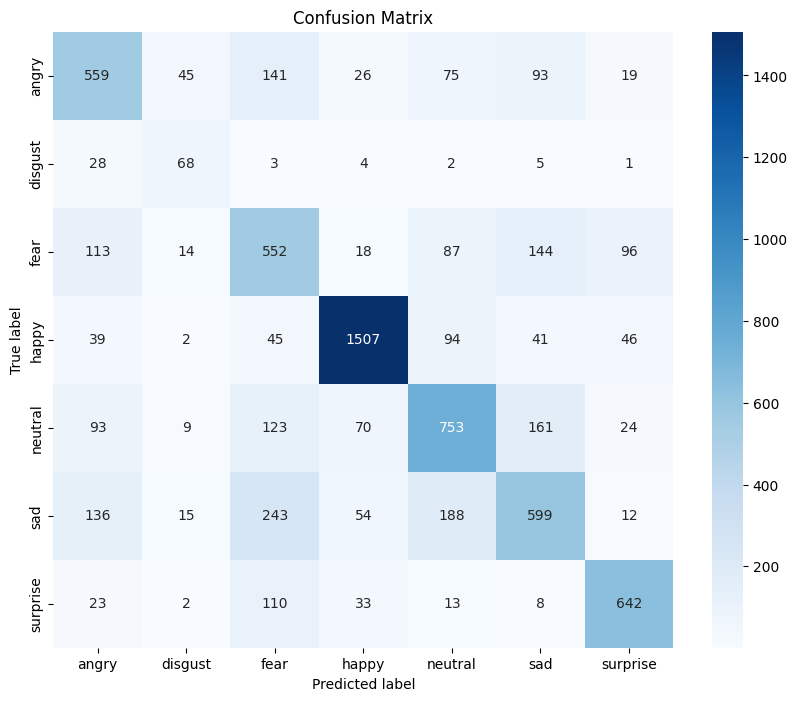

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
step = int(np.ceil(test_generator.samples/test_generator.batch_size))
predicted_classes = np.argmax(model.predict(test_generator, steps=step), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### classification report

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.56      0.58      0.57       958
     disgust       0.44      0.61      0.51       111
        fear       0.45      0.54      0.49      1024
       happy       0.88      0.85      0.86      1774
     neutral       0.62      0.61      0.62      1233
         sad       0.57      0.48      0.52      1247
    surprise       0.76      0.77      0.77       831

    accuracy                           0.65      7178
   macro avg       0.61      0.64      0.62      7178
weighted avg       0.66      0.65      0.65      7178



### AUC ROC plot for each class

In [ ]:
true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step


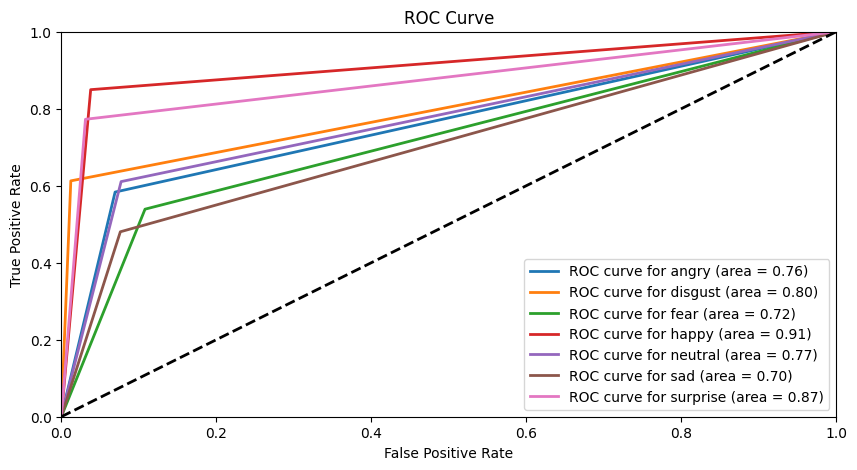

In [ ]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Gradio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import gradio as gr
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import cv2
from tensorflow.keras.preprocessing import image

In [ ]:
# Ensure your model is loaded here
# model = ... # Load your trained model
# Load your pre-trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/resnet_0.60_increase_4th_jan/resnet50_model.keras')

In [ ]:
# Emotion labels dictionary
emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
index_to_emotion = {v: k for k, v in emotion_labels.items()}
index_to_emotion

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [ ]:
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the image function
def prepare_image(img_pil):
    """Preprocess the PIL image to fit your model's input requirements."""
    img = img_pil.resize((224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Convert single image to a batch.
    img_array /= 255.0  # Rescale pixel values to [0,1], as done during training
    return img_array

# Define the prediction function
def predict_emotion(image):
    # Preprocess the image
    processed_image = prepare_image(image)
    # Make prediction using the model
    prediction = model.predict(processed_image)[0]  # Get the first prediction (batch size = 1)

    # Create a dictionary of emotions and probabilities
    emotion_percentages = {emotion: prob for emotion, prob in zip(index_to_emotion.values(), prediction)}

    # Sort emotions by probabilities in descending order
    sorted_emotions = sorted(emotion_percentages.items(), key=lambda x: x[1], reverse=True)

    # Plotting the results
    emotions = [item[0] for item in sorted_emotions]
    probabilities = [item[1] for item in sorted_emotions]

    plt.figure(figsize=(8, 4))
    plt.barh(emotions, probabilities, color='skyblue')
    plt.xlabel("Probability")
    plt.ylabel("Emotion")
    plt.title("Emotion Probabilities")
    plt.gca().invert_yaxis()  # Highest probability at the top
    plt.tight_layout()

    # Convert the plot to a NumPy array
    buf = plt.gcf()
    plt.close()
    return buf

# Define the Gradio interface
interface = gr.Interface(
    fn=predict_emotion,  # Your prediction function
    inputs=gr.Image(type="pil"),  # Input for uploading an image, directly compatible with PIL images
    outputs="plot",  # Display the plot directly in Gradio
    title="Emotion Detection",
    description="Upload an image and see the predicted emotion and probabilities for all emotions.",
    allow_flagging="never",  # Remove the flagging button
)

# Launch the Gradio interface
interface.launch()


/usr/local/lib/python3.10/dist-packages/gradio/interface.py:399: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://06746a58a445fb5005.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

image_path = '/content/fear.jfif'
img_pil = Image.open(image_path)

# Ensure the image is in RGB format
if img_pil.mode != 'RGB':
    img_pil = img_pil.convert('RGB')

img = img_pil.resize((224,224))
# img = img.convert('RGB')
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
processed_image = img_array / 255.0
# img2 = np.expand_dims(img_array, axis=0)

prediction = model.predict(processed_image)
print(prediction)

# Check the predicted class index and confidence
predicted_class_index = np.argmax(prediction)
print(f"Predicted Class Index: {predicted_class_index}")
print(f"Prediction Confidence: {np.max(prediction)}")
print(index_to_emotion[predicted_class_index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[0.07227479 0.03933382 0.07322894 0.18867266 0.44501418 0.08737558
  0.09410001]]
Predicted Class Index: 4
Prediction Confidence: 0.44501417875289917
neutral


In [ ]:
pip show tensorflow gradio numpy Pillow opencv-python


Name: tensorflow
Version: 2.17.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras
---
Name: gradio
Version: 5.9.1
Summary: Python library for easily interacting with trained machine learning models
Home-page: https://github.com/gradio-app/gradio
Author: 
Author-email: Abubakar Abid <gradio-team@huggingface.co>, Ali Abid <gradio-team@huggingface.co>, Ali Abdalla <gradio-team@huggingface.co>, Dawood Khan <gradio-team@huggingface.co>, Ahsen Khaliq <gradio-team@huggingface.co>, Pete Allen <gradio-team@huggingface.c